In [4]:
import os
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from pathlib import Path
from PIL import Image
from IPython.display import clear_output
#from scikitplot.metrics import plot_confusion_matrix, plot_roc
import tensorflow as tf

# From TensorFlow
from tensorflow.data.experimental import AUTOTUNE
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import VGG16, MobileNetV2, ResNet50V2, EfficientNetB0, EfficientNetB5, EfficientNetB7, DenseNet121, ResNet152V2
#from classification_models.tfkeras import Classifiers
#ResNet18, preprocess_input = Classifiers.get('resnet18')
#ResNet34, preprocess_input = Classifiers.get('resnet34')
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras
from keras.models import load_model, Model
from keras.initializers import glorot_uniform
from keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.python.client import device_lib
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import AUC, PrecisionAtRecall, SpecificityAtSensitivity, PrecisionAtRecall
from tensorflow.keras.losses import BinaryCrossentropy

# From scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score, roc_curve, roc_auc_score
from sklearn.utils import resample

set_global_policy('mixed_float16')

# GPU Availability

In [5]:
# Check for available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs detected: {gpus}")
else:
    print("No GPU detected.")

GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Constants and Hyperparameters

In [6]:
BATCH_SIZE = 64
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
IM_SIZE = 128

# Read the dataset
ROOT_DATASET_DIR = "../"
DATASET = os.path.join(ROOT_DATASET_DIR,"images")

# Evaluation Functions

In [7]:
# ploting model loss during training, created by Daniel: https://medium.com/geekculture/how-to-plot-model-loss-while-training-in-tensorflow-9fa1a1875a5
class plot_learning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

def partial_auc_score_tf(y_true, y_pred):
    tpr_threshold = 0.80
    max_fpr = 1 - tpr_threshold

    # Convert true labels and predictions to float
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Calculate the ROC curve with TensorFlow
    #fpr, tpr, _ = tf.compat.v1.metrics.auc(y_true, y_pred, curve='ROC')
    fpr, tpr, _ = AUC(y_true, y_pred)
    #fpr, tpr, _ = tfa.metrics.roc_curve(y_true, y_pred)
    
    # Find the index where fpr exceeds max_fpr
    stop_index = tf.where(fpr <= max_fpr)[-1]

    # Gather points up to the stop index
    fpr = fpr[:stop_index + 1]
    tpr = tpr[:stop_index + 1]

    # Add the max_fpr point
    fpr = tf.concat([fpr, [max_fpr]], axis=0)
    tpr = tf.concat([tpr, [tpr[-1]]], axis=0)

    # Calculate the partial AUC
    partial_auc_value = tf.reduce_sum(tf.multiply(tf.diff(fpr), (tpr[1:] + tpr[:-1]) / 2))

    return partial_auc_value

class PartialAUCMetric(tf.keras.metrics.Metric):
    def __init__(self, name='partial_auc', tpr_threshold=0.80, **kwargs):
        super(PartialAUCMetric, self).__init__(name=name, **kwargs)
        self.tpr_threshold = tpr_threshold
        self.partial_auc = self.add_weight(name='pAUC', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        partial_auc_value = tf.numpy_function(partial_auc_score_tf, [y_true, y_pred, self.tpr_threshold], tf.float32)
        self.partial_auc.assign(partial_auc_value)

    def result(self):
        return self.partial_auc

    def reset_states(self):
        self.partial_auc.assign(0.0)

def custom_loss(y_true, y_pred):
    # Initialize loss functions
    bce = BinaryCrossentropy() #(from_logits=True, reduction='none')
    sts = SpecificityAtSensitivity(0.8)

    # Compute loss functions
    loss1 = bce(y_true, y_pred)    
    loss2 = sts(y_true, y_pred)

    # Ensure consistent data types
    loss1 = tf.cast(loss1, tf.float32)
    loss2 = tf.cast(loss2, tf.float32)
    
    loss = -tf.math.log(1 - loss2 + 1e-7) + loss1
    return loss

# Image Preprocessing Functions

In [16]:
def hair_remove(image):
    # convert image to grayScale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # kernel for morphologyEx
    kernel = cv2.getStructuringElement(1,(17,17))
    
    # apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    
    # apply thresholding to blackhat
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    
    # inpaint with original image and threshold image
    final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)
    
    return final_image

# Function for custom normalization
def custom_normalization(image):
    image = image / 255.0
    mean = tf.constant(MEAN, dtype=image.dtype)
    std = tf.constant(STD, dtype=image.dtype)
    image = (image - mean) / std  # Normalize each channel
    return image

# Function to rotate an image by an angle
def rotate_image(image, angle):
    radians = angle * (np.pi / 180)  # Convert degrees to radians
    return tfa.image.rotate(image, radians)

# Image augmentation
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)  # Horizontal flip
    image = tf.image.random_flip_up_down(image) # Vertical flip
    angle = tf.random.uniform([], minval=-20, maxval=20)
    image = rotate_image(image, angle)  # Random rotation
    image = tf.image.random_brightness(image, max_delta=0.5)  # Random brightness
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)  # Random contrast
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)  # Random saturation
    #image = random_zoom(image)  # Random zoom (from additional code)
    return image, label

# Parse and process images
def parse_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IM_SIZE, IM_SIZE]) #, method=tf.image.ResizeMethod.LANCZOS3)
    #image = hair_remove(image)
    image = custom_normalization(image)
    return image, label

# Generate dataset from file paths
def generate_dataset(file_paths, labels, batch_size, is_training):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(buffer_size=1000)  # Use a reasonable buffer size
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# List image paths and labels
def get_image_paths_and_labels(directory):
    data_dir = Path(directory)    
    all_image_paths = list(data_dir.glob('*/*.jpg'))
    all_image_paths = [str(path) for path in all_image_paths]    
    all_labels = [0 if '\\0' in str(path) else 1 for path in all_image_paths]
    return all_image_paths, all_labels

# Resampling Function

In [9]:
# Function to undersample the majority class and oversample the minority class
def balance_classes(image_paths, labels, majority_size=None, minority_size=None):
    # Convert to numpy arrays for easier manipulation
    image_paths = np.array(image_paths)
    labels = np.array(labels)
    
    # Separate the majority and minority classes
    majority_class = image_paths[labels == 0]
    majority_labels = labels[labels == 0]
    
    minority_class = image_paths[labels == 1]
    minority_labels = labels[labels == 1]
    
    # Undersample the majority class if majority_size is specified
    if majority_size and (majority_size < len(majority_class)):
        majority_class_downsampled, majority_labels_downsampled = resample(
            majority_class,
            majority_labels,
            replace=False,  # Sample without replacement
            n_samples=majority_size,  # Number of samples after undersampling
            random_state=42  # For reproducibility
        )
    else:
        majority_class_downsampled, majority_labels_downsampled = majority_class, majority_labels
    
    # Oversample the minority class if minority_size is specified
    if minority_size and (minority_size > len(minority_class)):
        minority_class_upsampled, minority_labels_upsampled = resample(
            minority_class,
            minority_labels,
            replace=True,  # Sample with replacement
            n_samples=minority_size,  # Number of samples after oversampling
            random_state=42  # For reproducibility
        )
    else:
        minority_class_upsampled, minority_labels_upsampled = minority_class, minority_labels
    
    # Combine the undersampled majority class and upsampled minority class
    balanced_image_paths = np.concatenate([majority_class_downsampled, minority_class_upsampled])
    balanced_labels = np.concatenate([majority_labels_downsampled, minority_labels_upsampled])
    
    return balanced_image_paths.tolist(), balanced_labels.tolist()

# Create Datasets

In [10]:
# Split the data into training and validation sets
all_image_paths, all_labels = get_image_paths_and_labels(DATASET + '/train')

# Frequencies of each class
n_class_0 = all_labels.count(0)
n_class_1 = all_labels.count(1)

# Balance the classes by undersampling and oversampling
train_paths_balanced, train_labels_balanced = balance_classes(
    all_image_paths, 
    all_labels, 
    majority_size=n_class_1 * 10,  # Set this to the desired number of majority samples
    minority_size=n_class_1 * 10   # Set this to the desired number of minority samples
)

# Split the data into training and validation sets
train_paths, validation_paths, train_labels, validation_labels = train_test_split(
    train_paths_balanced, train_labels_balanced, 
    test_size=0.2, stratify=train_labels_balanced, random_state=42
)

# Create datasets
train_dataset = generate_dataset(train_paths, train_labels, BATCH_SIZE, is_training=True)
validation_dataset = generate_dataset(validation_paths, validation_labels, BATCH_SIZE, is_training=False)
test_paths, test_labels = get_image_paths_and_labels(DATASET + '/test')
test_dataset = generate_dataset(test_paths, test_labels, BATCH_SIZE, is_training=False)

# Create CNNs

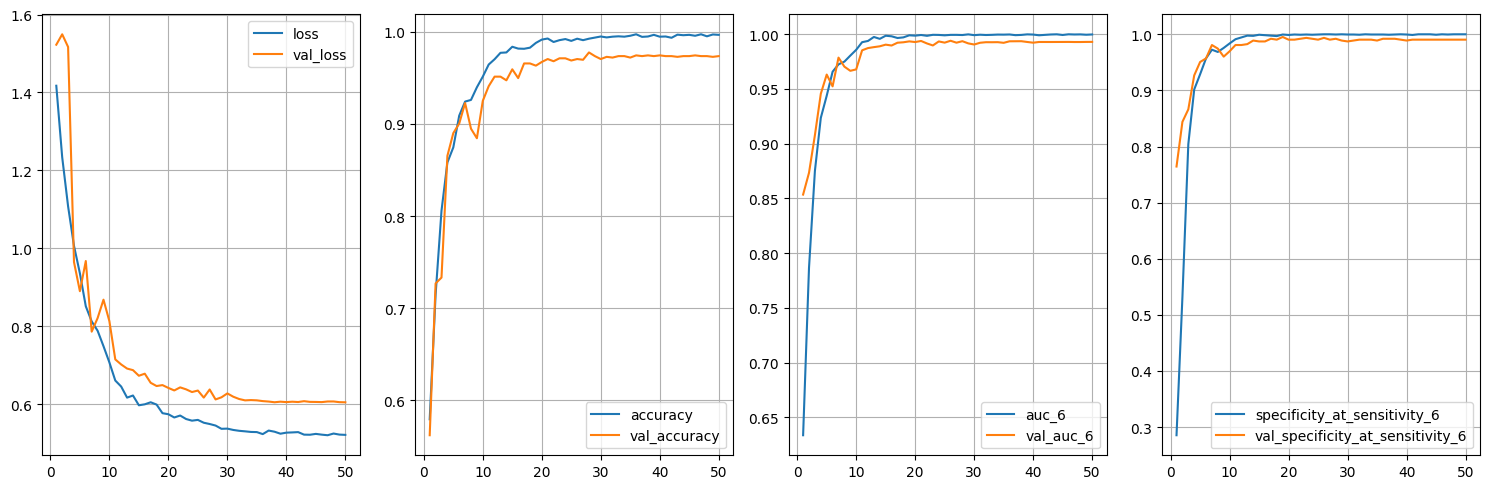

79/79 [==============================] - 17s 212ms/step - loss: 0.5215 - accuracy: 0.9968 - auc_6: 0.9997 - specificity_at_sensitivity_6: 1.0000 - val_loss: 0.6051 - val_accuracy: 0.9737 - val_auc_6: 0.9929 - val_specificity_at_sensitivity_6: 0.9904 - lr: 1.0000e-07


In [15]:
VERSION = 'v34'
EPOCHS = 50
LEARN_RATE = 0.0001
REG_RATE = 0.001
NEURONS_1 = 256
NEURONS_2 = 128
NEURONS_3 = 64
DROPOUT_RATE = 0.5

with tf.device('/GPU:0'):
    # Load the pre-trained ResNet50V2 model
    #wgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))
    #base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))
    #base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))
    #base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))
    base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))

    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = True

    # Get the output tensor of the base ResNet50V2 model
    base_output = base_model.output

    # Flatten the output tensor
    #x = Flatten()(base_output)
    # Use Global Average Pooling
    x = GlobalAveragePooling2D()(base_output)    
    # Add fully connected layers with dropout
    x = Dense(NEURONS_1, kernel_initializer=glorot_uniform(seed=42), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(REG_RATE))(x)
    x = Dropout(DROPOUT_RATE)(x)
    #x = BatchNormalization()(x)    
    x = Dense(NEURONS_2, kernel_initializer=glorot_uniform(seed=42), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(REG_RATE))(x)
    x = Dropout(DROPOUT_RATE)(x)
    #x = BatchNormalization()(x)    
    x = Dense(NEURONS_3, kernel_initializer=glorot_uniform(seed=42), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(REG_RATE))(x)
    x = Dropout(DROPOUT_RATE)(x)    
    #x = BatchNormalization()(x)

    # Output layer with sigmoid activation for binary classification
    output = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=output)

# Compile de model
optimizer = Adam(learning_rate=LEARN_RATE)
eval_metrics = ["accuracy", AUC(from_logits=False), SpecificityAtSensitivity(sensitivity=0.8)]
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=eval_metrics)

# Checkpoint callbacks
best_checkpoint_path = f"../models/rn152_nn{NEURONS_1}_lr{int(LEARN_RATE * 10000):04}_relu_batch{BATCH_SIZE}_epoch{EPOCHS}_{VERSION}_best.keras"
best_checkpoint_callback = ModelCheckpoint(filepath=best_checkpoint_path, save_best_only=True)

final_checkpoint_path = f"../models/rn152_nn{NEURONS_1}_lr{int(LEARN_RATE * 10000):04}_relu_batch{BATCH_SIZE}_epoch{EPOCHS}_{VERSION}_final.keras"
final_checkpoint_callback = ModelCheckpoint(filepath=final_checkpoint_path)

reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)

print(f"Best-performing model: {best_checkpoint_path}")
print(f"Last-epoch model: {final_checkpoint_path}")

# Train the model
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,    
    epochs=EPOCHS,
    verbose=1,
    validation_data=validation_dataset,    
    #class_weight=class_weight,
    callbacks=[plot_learning(), reduce_lr_callback, best_checkpoint_callback, final_checkpoint_callback] #
)

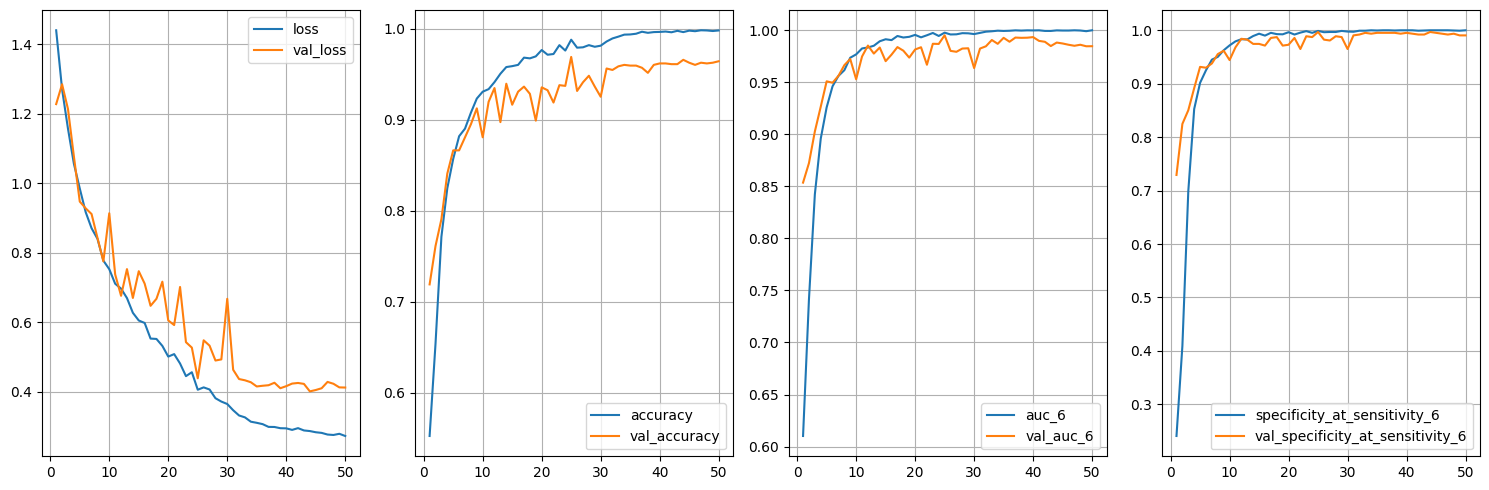

79/79 [==============================] - 16s 191ms/step - loss: 0.2729 - accuracy: 0.9980 - auc_6: 1.0000 - specificity_at_sensitivity_6: 1.0000 - val_loss: 0.4122 - val_accuracy: 0.9642 - val_auc_6: 0.9847 - val_specificity_at_sensitivity_6: 0.9904 - lr: 1.0000e-06


In [18]:
VERSION = 'v41'
EPOCHS = 50
LEARN_RATE = 0.0001
REG_RATE = 0.001
NEURONS_1 = 256
NEURONS_2 = 128
NEURONS_3 = 64
DROPOUT_RATE = 0.5
EVALUATION = 'relu'

with tf.device('/GPU:0'):
    # Load the pre-trained ResNet50V2 model
    base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))

    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = True

    # Get the output tensor of the base ResNet50V2 model
    base_output = base_model.output

    # Flatten the output tensor
    #x = Flatten()(base_output)
    # Use Global Average Pooling
    x = GlobalAveragePooling2D()(base_output)    
    # Add fully connected layers with dropout
    x = Dense(NEURONS_1, kernel_initializer=glorot_uniform(seed=42), activation=EVALUATION, kernel_regularizer=tf.keras.regularizers.l2(REG_RATE))(x)
    x = Dropout(DROPOUT_RATE)(x)
    #x = BatchNormalization()(x)    
    x = Dense(NEURONS_2, kernel_initializer=glorot_uniform(seed=42), activation=EVALUATION, kernel_regularizer=tf.keras.regularizers.l2(REG_RATE))(x)
    x = Dropout(DROPOUT_RATE)(x)
    #x = BatchNormalization()(x)    
    x = Dense(NEURONS_3, kernel_initializer=glorot_uniform(seed=42), activation=EVALUATION, kernel_regularizer=tf.keras.regularizers.l2(REG_RATE))(x)
    x = Dropout(DROPOUT_RATE)(x)    
    #x = BatchNormalization()(x)

    # Output layer with sigmoid activation for binary classification
    output = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=output)

# Compile de model
optimizer = Adam(learning_rate=LEARN_RATE)
eval_metrics = ["accuracy", AUC(from_logits=False), SpecificityAtSensitivity(sensitivity=0.8)]
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=eval_metrics)

# Checkpoint callbacks
best_checkpoint_path = f"../models/rn152v2_nn{NEURONS_1}_lr{int(LEARN_RATE * 10000):04}_{EVALUATION}_batch{BATCH_SIZE}_epoch{EPOCHS}_{VERSION}_best.keras"
best_checkpoint_callback = ModelCheckpoint(filepath=best_checkpoint_path, save_best_only=True)

final_checkpoint_path = f"../models/rn152v2_nn{NEURONS_1}_lr{int(LEARN_RATE * 10000):04}_{EVALUATION}_batch{BATCH_SIZE}_epoch{EPOCHS}_{VERSION}_final.keras"
final_checkpoint_callback = ModelCheckpoint(filepath=final_checkpoint_path)

reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7)

print(f"Best-performing model: {best_checkpoint_path}")
print(f"Last-epoch model: {final_checkpoint_path}")

# Train the model
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,    
    epochs=EPOCHS,
    verbose=1,
    validation_data=validation_dataset,    
    callbacks=[plot_learning(), reduce_lr_callback, best_checkpoint_callback, final_checkpoint_callback]
)